[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<username>/<repo>/<path>/<to>/<notebook>.ipynb)


In [21]:
%autosave 60

Autosaving every 60 seconds


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [23]:
df = pd.read_csv("F_14.csv",  parse_dates=["DATEPRD"], index_col="DATEPRD")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1908 entries, 2010-01-01 to 2015-03-23
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ON_STREAM_HRS             1828 non-null   float64
 1   AVG_DOWNHOLE_PRESSURE     1828 non-null   float64
 2   AVG_DOWNHOLE_TEMPERATURE  1828 non-null   float64
 3   AVG_DP_TUBING             1828 non-null   float64
 4   AVG_ANNULUS_PRESS         1764 non-null   float64
 5   AVG_CHOKE_SIZE_P          1802 non-null   float64
 6   AVG_WHP_P                 1828 non-null   float64
 7   AVG_WHT_P                 1828 non-null   float64
 8   DP_CHOKE_SIZE             1828 non-null   float64
 9   BORE_OIL_VOL              1828 non-null   float64
 10  BORE_GAS_VOL              1828 non-null   float64
 11  BORE_WAT_VOL              1828 non-null   float64
 12  F_4_ON_STREAM_HRS         1908 non-null   float64
 13  F_4_BORE_WI_VOL           1862 non-null   flo

In [25]:
# remove average annulur pressure and pressure drop across the wellbore
df = df.drop(["AVG_ANNULUS_PRESS"], axis=1)

In [26]:
#Correct the errors found in data points (24.31, 25) by changing the value to 24 hours.
# This is because the preceding and subsequent values of on-stream hours are 24, and the oil volume at these points is close to that at (24.31, 25) hours.
df["ON_STREAM_HRS"]  = np.where(df["ON_STREAM_HRS"] > 24 , 24, df["ON_STREAM_HRS"])

In [27]:
# the values for all variables are corrupted in the period of "2012-09-02" & "2012-09-28"
# on strem hours is set to zero becasue oil production is zero
df.loc["2012-09-02":"2012-09-28",'ON_STREAM_HRS'] = 0
# average reservoir presure in this period is corrupted
df.loc["2012-09-02":"2012-09-03",'AVG_DOWNHOLE_PRESSURE'] = np.nan
# # average reservori pressure is decreaseing and decreasing; therefore, is imputated with linear interpolation 
df.loc["2012-09-01":"2012-09-27",'AVG_DOWNHOLE_PRESSURE'].interpolate(inplace = True, limit_direction ='forward')
# # average reservoir temperature in this period is corrupted
df.loc["2012-09-02":"2012-09-03",'AVG_DOWNHOLE_TEMPERATURE'] = np.nan
# # average reservori pressure is decreaseing and decreasing; therefore, is imputated with linear interpolation 
df.loc["2012-09-01":"2012-09-27",'AVG_DOWNHOLE_TEMPERATURE'].interpolate(inplace = True,limit_direction ='forward')
# The average choke size should be set to zero when the well is not in production
df.loc[df['ON_STREAM_HRS'] == 0, 'AVG_CHOKE_SIZE_P'] = 0
df["2012-09-01":"2012-09-27"] = df["2012-09-01":"2012-09-27"].interpolate(limit_direction ='forward')
# use ffill to fill forward missing values
df.loc["2012-09-27":"2012-09-29"] = df.loc["2012-09-27":"2012-09-29"].fillna(method='ffill')

# the on stream injection volumne for F-5 on this day is zero, which means the injection rate should be zero too
df.loc["2012-09-28"]['F_5_BORE_WI_VOL'] = 0

mask = ((df["BORE_GAS_VOL"] == 0) | (df["BORE_WAT_VOL"] == 0) | (df["BORE_OIL_VOL"] == 0))
df["ON_STREAM_HRS"] = np.where(mask, 0, df["ON_STREAM_HRS"])


* BORE_GAS_VOL	& BORE_WAT_VOL

In [ ]:
df.loc[(df["ON_STREAM_HRS"] < 5) & (df["ON_STREAM_HRS"] > 0)]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-03-02,1.52500,4056.406377,217.045948,2584.079554,7.913890,1472.326823,53.842397,1110.605408,324.617125,1.301300e+05,195.235721,0.00000,NaN,0.00000,NaN
2010-09-14,4.75833,4140.175978,222.769781,2924.567784,16.267234,1215.608194,182.678748,762.403034,892.146736,7.816608e+05,1244.124537,24.00000,26934.455835,24.00000,25510.780101
2010-11-15,3.32500,3544.258430,222.801656,2873.999121,68.520934,670.259310,196.180465,188.820733,1882.540313,1.591700e+06,3437.192799,14.25000,15265.370326,14.25000,15120.704682
2011-07-09,1.57500,4107.239553,215.640599,3072.494546,10.228295,1034.745006,88.634206,588.271092,122.525510,2.334540e+05,1029.327505,1.15833,1301.990794,1.15833,1195.064014
2011-07-15,2.99166,3956.316807,217.010336,2928.712393,20.342270,1027.604414,126.493370,595.570934,888.498645,4.734182e+05,1118.076732,1.82500,1484.395302,1.82500,3163.774732
2011-07-30,2.34167,3623.153116,218.279284,2891.679323,46.967670,731.473794,190.347537,299.517797,1673.907295,1.094579e+06,2368.553978,2.00834,2698.328747,1.84167,3195.223785
2011-12-06,4.80833,3555.413107,217.107458,2942.748927,15.159327,612.664180,186.312893,181.006326,3574.688058,2.564708e+06,7706.464641,4.64167,6725.065494,4.64167,7438.958997
2011-12-13,4.30833,3535.523948,217.067847,2928.692696,14.023717,606.831251,184.451864,170.638752,3593.997777,2.637858e+06,7681.305399,4.30833,6610.590941,4.30833,7220.702569
2011-12-29,2.85833,3848.105625,216.128178,3034.741521,4.824328,813.364103,142.570095,351.724686,1000.520172,8.498937e+05,3453.923695,2.52500,2900.231668,2.52500,2736.067611


In [ ]:
# check why the oil prodcution is zero
df.loc["2012-08-10":"2012-09-25"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2012-08-10,24.000,3341.754451,215.418140,2872.915071,100.000000,468.839380,188.058434,44.978000,6557.064652,5.777168e+06,17650.466506,24.00000,26615.333554,24.00000,26988.319322
2012-08-11,24.000,3340.121417,215.411423,2872.940580,100.000000,467.180837,188.020174,45.084697,6587.318641,5.877184e+06,17637.509496,24.00000,35963.879049,24.00000,42971.357038
2012-08-12,24.000,3347.914129,215.409665,2878.807199,99.998988,469.106929,186.100771,44.361759,6556.246977,5.817801e+06,17865.326436,24.00000,30501.807524,24.00000,33438.520093
2012-08-13,0.625,3667.893411,215.395826,2998.507324,7.777673,669.386087,182.686410,249.518573,1273.875341,1.325755e+05,-372.293889,4.45833,4917.373927,21.12499,26662.507133
2012-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.00000,0.000000
2012-08-15,0.000,4266.516108,211.477820,4211.907660,0.000000,54.608449,60.681056,45.099340,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-16,0.000,4266.122331,211.191710,4217.272896,0.000000,48.849435,60.916640,46.136795,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-17,0.000,4265.677210,211.004366,4220.144788,0.000000,45.532422,60.144584,42.553782,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.00000,0.000000


In [ ]:
# check why the oil prodcution is zero
df.loc["2012-09-15"].ON_STREAM_HRS = 0

In [ ]:
df.loc["2012-08-10":"2012-09-25"] = df.loc["2012-08-10":"2012-09-25"].bfill(axis=0)

In [ ]:
# check wy the oil prodcution is zero
df.loc["2012-08-10":"2012-09-25"]


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2012-08-10,24.000,3341.754451,215.418140,2872.915071,100.000000,468.839380,188.058434,44.978000,6557.064652,5.777168e+06,17650.466506,24.00000,26615.333554,24.00000,26988.319322
2012-08-11,24.000,3340.121417,215.411423,2872.940580,100.000000,467.180837,188.020174,45.084697,6587.318641,5.877184e+06,17637.509496,24.00000,35963.879049,24.00000,42971.357038
2012-08-12,24.000,3347.914129,215.409665,2878.807199,99.998988,469.106929,186.100771,44.361759,6556.246977,5.817801e+06,17865.326436,24.00000,30501.807524,24.00000,33438.520093
2012-08-13,0.625,3667.893411,215.395826,2998.507324,7.777673,669.386087,182.686410,249.518573,1273.875341,1.325755e+05,-372.293889,4.45833,4917.373927,21.12499,26662.507133
2012-08-14,0.000,4266.516108,211.477820,4211.907660,0.000000,54.608449,60.681056,45.099340,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-15,0.000,4266.516108,211.477820,4211.907660,0.000000,54.608449,60.681056,45.099340,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-16,0.000,4266.122331,211.191710,4217.272896,0.000000,48.849435,60.916640,46.136795,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-17,0.000,4265.677210,211.004366,4220.144788,0.000000,45.532422,60.144584,42.553782,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000
2012-08-18,0.000,4264.789289,210.737048,4221.712211,0.000000,43.077078,61.091096,39.592547,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.00000,0.000000


In [ ]:
# replace the negative value in the water volume column with  positive one
df.loc["2012-08-13"].BORE_WAT_VOL = df.loc["2012-08-13"].BORE_WAT_VOL *-1

In [ ]:
df.loc[(df["ON_STREAM_HRS"] < 5) & (df["ON_STREAM_HRS"] > 0)]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-03-02,1.52500,4056.406377,217.045948,2584.079554,7.913890,1472.326823,53.842397,1110.605408,324.617125,1.301300e+05,195.235721,0.00000,NaN,0.00000,NaN
2010-09-14,4.75833,4140.175978,222.769781,2924.567784,16.267234,1215.608194,182.678748,762.403034,892.146736,7.816608e+05,1244.124537,24.00000,26934.455835,24.00000,25510.780101
2010-11-15,3.32500,3544.258430,222.801656,2873.999121,68.520934,670.259310,196.180465,188.820733,1882.540313,1.591700e+06,3437.192799,14.25000,15265.370326,14.25000,15120.704682
2011-07-09,1.57500,4107.239553,215.640599,3072.494546,10.228295,1034.745006,88.634206,588.271092,122.525510,2.334540e+05,1029.327505,1.15833,1301.990794,1.15833,1195.064014
2011-07-15,2.99166,3956.316807,217.010336,2928.712393,20.342270,1027.604414,126.493370,595.570934,888.498645,4.734182e+05,1118.076732,1.82500,1484.395302,1.82500,3163.774732
2011-07-30,2.34167,3623.153116,218.279284,2891.679323,46.967670,731.473794,190.347537,299.517797,1673.907295,1.094579e+06,2368.553978,2.00834,2698.328747,1.84167,3195.223785
2011-12-06,4.80833,3555.413107,217.107458,2942.748927,15.159327,612.664180,186.312893,181.006326,3574.688058,2.564708e+06,7706.464641,4.64167,6725.065494,4.64167,7438.958997
2011-12-13,4.30833,3535.523948,217.067847,2928.692696,14.023717,606.831251,184.451864,170.638752,3593.997777,2.637858e+06,7681.305399,4.30833,6610.590941,4.30833,7220.702569
2011-12-29,2.85833,3848.105625,216.128178,3034.741521,4.824328,813.364103,142.570095,351.724686,1000.520172,8.498937e+05,3453.923695,2.52500,2900.231668,2.52500,2736.067611


* AVG_DOWNHOLE_PRESSUR

In [ ]:
df.loc[df["ON_STREAM_HRS"] > 0].describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1.741000e+03,1741.000000,1741.000000,1736.000000,1741.000000,1728.000000
mean,22.930750,3551.571695,214.959003,3001.723029,78.546578,558.811605,189.251763,121.067688,7624.281239,6.453086e+06,19767.808049,22.190732,34215.704712,22.211625,34291.703045
std,3.660716,333.024784,15.569395,295.154554,24.491902,127.953273,8.348865,110.004519,4876.636636,3.985730e+06,5027.023134,5.086386,11008.729250,5.116114,10379.591431
min,0.625000,0.000000,32.000000,104.707961,2.485842,414.514894,53.842397,26.986429,27.046186,3.023006e+04,195.235721,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3505.917280,212.107118,2872.867429,59.358247,467.179934,187.433905,42.524312,3488.643449,2.854252e+06,17075.577817,24.000000,28854.426294,24.000000,29019.386792
50%,24.000000,3563.802481,215.201908,2985.330417,96.037641,502.299302,190.167742,75.707545,6552.535989,5.835679e+06,21011.489698,24.000000,35562.230090,24.000000,35506.105672
75%,24.000000,3697.586548,220.335749,3198.274370,100.000000,601.060085,192.641538,159.410231,11364.052403,9.853613e+06,22803.268044,24.000000,40648.072464,24.000000,40148.925003
max,24.000000,4174.252236,224.190920,3432.471293,100.000000,1472.326823,200.317251,1110.605408,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


In [ ]:
# insect the low vallues of average downhole pressure
df.loc[(df["ON_STREAM_HRS"] > 0) & (df["AVG_DOWNHOLE_PRESSURE"] < 20)]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-02-15,13.7,0.0,32.0,1004.517786,28.839026,1004.517786,165.803947,553.356496,6329.247712,4.856041e+06,4231.029794,11.07500,19743.715473,10.32500,17296.979150
2010-02-16,24.0,0.0,32.0,866.871657,41.811064,866.871657,187.460535,397.480589,16680.955100,1.314600e+07,14895.718157,24.00000,49794.803365,24.00000,52400.748596
2010-02-17,24.0,0.0,32.0,867.512968,41.785463,867.512968,185.725022,398.272015,16393.762348,1.292608e+07,14438.826315,24.00000,48775.257270,24.00000,53774.451831
2010-02-18,21.6,0.0,32.0,896.305278,39.018513,896.305278,184.233170,424.086643,13470.824464,1.062037e+07,12444.704763,19.83334,44893.513749,19.83334,50718.863507
2010-02-19,24.0,0.0,32.0,877.896190,41.378970,877.896190,192.113731,408.609501,16107.701762,1.270653e+07,15385.191218,24.00000,45695.945729,24.00000,53422.621790
2010-02-20,24.0,0.0,32.0,885.262284,40.981887,885.262284,193.308051,416.372261,15845.982743,1.249969e+07,15532.498582,24.00000,46320.728076,24.00000,54312.853228
2010-02-21,24.0,0.0,32.0,887.570896,40.096205,887.570896,193.521431,418.251596,15678.296392,1.236147e+07,15519.478674,24.00000,44189.434548,24.00000,57414.512629
2010-02-22,24.0,0.0,32.0,894.000123,40.834275,894.000123,193.767757,424.722487,15630.368035,1.236109e+07,15589.484266,24.00000,43088.377460,24.00000,60050.679482
2013-09-28,24.0,0.0,32.0,467.593838,99.227820,467.593838,190.041130,44.005459,5026.816632,4.284150e+06,25382.027491,24.00000,30681.895778,24.00000,33266.501816


In [ ]:
#avergae downhole pressure and tempwerature are corrupted
df.loc["2010-02-07":"2010-02-27"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-02-07,24.00000,3594.214970,223.279101,2729.827109,41.979399,864.387861,193.466895,395.527596,16020.210496,1.275398e+07,16164.624548,24.00000,49596.404828,24.00000,47953.774186
2010-02-08,24.00000,3578.127596,223.310928,2732.519142,43.334740,845.608454,193.952946,375.230383,16407.033848,1.296437e+07,17298.866093,24.00000,49526.720631,24.00000,48145.111268
2010-02-09,24.00000,3588.018728,223.323423,2735.243057,42.843234,852.775672,193.950139,383.180464,16222.365009,1.281081e+07,17137.280859,24.00000,46859.088970,24.00000,50437.991201
2010-02-10,24.00000,2735.842924,177.108733,1865.082428,41.727705,870.760496,193.357691,402.951703,15861.204084,1.255093e+07,16454.270326,24.00000,45801.378467,24.00000,51193.225314
2010-02-11,24.00000,3628.682766,223.296603,2740.441025,40.501278,888.241741,193.680124,420.714650,15729.621247,1.239212e+07,14343.095398,24.00000,46015.623461,24.00000,51129.747909
2010-02-12,24.00000,3665.907003,223.278729,2745.819885,38.670408,920.087118,193.413885,456.185115,14899.240451,1.168902e+07,14136.978305,24.00000,44006.365367,24.00000,47281.678474
2010-02-13,24.00000,3661.378318,223.188413,2736.465891,38.785386,924.912427,193.216220,460.194944,15262.477013,1.178482e+07,14843.072443,24.00000,29389.907011,24.00000,19147.351579
2010-02-14,15.33334,3223.758742,201.480217,2332.853883,34.260503,890.904859,182.553686,462.462454,9037.828851,7.112770e+06,8102.345321,13.59167,26260.802024,13.59167,21412.331020
2010-02-15,13.70000,0.000000,32.000000,1004.517786,28.839026,1004.517786,165.803947,553.356496,6329.247712,4.856041e+06,4231.029794,11.07500,19743.715473,10.32500,17296.979150


In [ ]:
df["2010-02-10":"2010-02-27"]["AVG_DOWNHOLE_PRESSURE"] 

DATEPRD
2010-02-10    2735.842924
2010-02-11    3628.682766
2010-02-12    3665.907003
2010-02-13    3661.378318
2010-02-14    3223.758742
2010-02-15       0.000000
2010-02-16       0.000000
2010-02-17       0.000000
2010-02-18       0.000000
2010-02-19       0.000000
2010-02-20       0.000000
2010-02-21       0.000000
2010-02-22       0.000000
2010-02-23    1032.010168
2010-02-24    3637.945870
2010-02-25     717.217989
2010-02-26    3703.984804
2010-02-27    3644.620642
Name: AVG_DOWNHOLE_PRESSURE, dtype: float64

In [ ]:
#  replace the corrupted values with NaN then impute the downhole pressure with linear interpolation and temperature with 
df.loc["2010-02-10":"2010-02-27","AVG_DOWNHOLE_PRESSURE"] =  df.loc["2010-02-10":"2010-02-27","AVG_DOWNHOLE_PRESSURE"].apply(lambda x: np.nan if x < 3300 else x)
df.loc["2010-02-09":"2010-02-27","AVG_DOWNHOLE_PRESSURE"] = df.loc["2010-02-09":"2010-02-27","AVG_DOWNHOLE_PRESSURE"].interpolate(
    method ='linear', limit_direction ='forward')
# downhole temperature
df.loc["2010-02-10":"2010-02-27","AVG_DOWNHOLE_TEMPERATURE"] = df["2010-02-10":"2010-02-27"]["AVG_DOWNHOLE_TEMPERATURE"].apply(lambda x:np.nan if x < 220  else x) 
df.loc["2010-02-10":"2010-02-27","AVG_DOWNHOLE_TEMPERATURE"] = df["2010-02-10":"2010-02-27"]["AVG_DOWNHOLE_TEMPERATURE"].apply(
    lambda x:np.nan if x < 220  else x).replace(
        np.nan,df.loc["2010-02-10":"2010-02-27","AVG_DOWNHOLE_TEMPERATURE"].mean() )

In [ ]:
df["2010-02-07":"2010-02-27"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-02-07,24.00000,3594.214970,223.279101,2729.827109,41.979399,864.387861,193.466895,395.527596,16020.210496,1.275398e+07,16164.624548,24.00000,49596.404828,24.00000,47953.774186
2010-02-08,24.00000,3578.127596,223.310928,2732.519142,43.334740,845.608454,193.952946,375.230383,16407.033848,1.296437e+07,17298.866093,24.00000,49526.720631,24.00000,48145.111268
2010-02-09,24.00000,3588.018728,223.323423,2735.243057,42.843234,852.775672,193.950139,383.180464,16222.365009,1.281081e+07,17137.280859,24.00000,46859.088970,24.00000,50437.991201
2010-02-10,24.00000,3608.350747,223.296296,1865.082428,41.727705,870.760496,193.357691,402.951703,15861.204084,1.255093e+07,16454.270326,24.00000,45801.378467,24.00000,51193.225314
2010-02-11,24.00000,3628.682766,223.296603,2740.441025,40.501278,888.241741,193.680124,420.714650,15729.621247,1.239212e+07,14343.095398,24.00000,46015.623461,24.00000,51129.747909
2010-02-12,24.00000,3665.907003,223.278729,2745.819885,38.670408,920.087118,193.413885,456.185115,14899.240451,1.168902e+07,14136.978305,24.00000,44006.365367,24.00000,47281.678474
2010-02-13,24.00000,3661.378318,223.188413,2736.465891,38.785386,924.912427,193.216220,460.194944,15262.477013,1.178482e+07,14843.072443,24.00000,29389.907011,24.00000,19147.351579
2010-02-14,15.33334,3659.248095,223.296296,2332.853883,34.260503,890.904859,182.553686,462.462454,9037.828851,7.112770e+06,8102.345321,13.59167,26260.802024,13.59167,21412.331020
2010-02-15,13.70000,3657.117873,223.296296,1004.517786,28.839026,1004.517786,165.803947,553.356496,6329.247712,4.856041e+06,4231.029794,11.07500,19743.715473,10.32500,17296.979150


In [ ]:
# fix the pressure drop along the tubing
df.loc["2010-02-07":"2010-02-27", "AVG_DP_TUBING"]  = df["2010-02-07":"2010-02-27"].AVG_DOWNHOLE_PRESSURE - df["2010-02-07":"2010-02-27"].AVG_WHP_P

In [ ]:
df["2010-02-07":"2010-02-27"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-02-07,24.00000,3594.214970,223.279101,2729.827109,41.979399,864.387861,193.466895,395.527596,16020.210496,1.275398e+07,16164.624548,24.00000,49596.404828,24.00000,47953.774186
2010-02-08,24.00000,3578.127596,223.310928,2732.519142,43.334740,845.608454,193.952946,375.230383,16407.033848,1.296437e+07,17298.866093,24.00000,49526.720631,24.00000,48145.111268
2010-02-09,24.00000,3588.018728,223.323423,2735.243057,42.843234,852.775672,193.950139,383.180464,16222.365009,1.281081e+07,17137.280859,24.00000,46859.088970,24.00000,50437.991201
2010-02-10,24.00000,3608.350747,223.296296,2737.590251,41.727705,870.760496,193.357691,402.951703,15861.204084,1.255093e+07,16454.270326,24.00000,45801.378467,24.00000,51193.225314
2010-02-11,24.00000,3628.682766,223.296603,2740.441025,40.501278,888.241741,193.680124,420.714650,15729.621247,1.239212e+07,14343.095398,24.00000,46015.623461,24.00000,51129.747909
2010-02-12,24.00000,3665.907003,223.278729,2745.819885,38.670408,920.087118,193.413885,456.185115,14899.240451,1.168902e+07,14136.978305,24.00000,44006.365367,24.00000,47281.678474
2010-02-13,24.00000,3661.378318,223.188413,2736.465891,38.785386,924.912427,193.216220,460.194944,15262.477013,1.178482e+07,14843.072443,24.00000,29389.907011,24.00000,19147.351579
2010-02-14,15.33334,3659.248095,223.296296,2768.343236,34.260503,890.904859,182.553686,462.462454,9037.828851,7.112770e+06,8102.345321,13.59167,26260.802024,13.59167,21412.331020
2010-02-15,13.70000,3657.117873,223.296296,2652.600086,28.839026,1004.517786,165.803947,553.356496,6329.247712,4.856041e+06,4231.029794,11.07500,19743.715473,10.32500,17296.979150


In [ ]:
# fixing the zero downhole pressure
df["2013-09-23":"2013-10-03"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-09-23,24.00000,3597.688621,212.739127,3127.452410,100.000000,470.236211,191.650081,42.474425,3937.358537,3.283687e+06,21629.023303,24.00000,35689.300702,24.0,41347.147492
2013-09-24,24.00000,3592.840871,212.828124,3121.709725,100.000000,471.131146,191.546557,43.237590,4129.134863,3.457000e+06,23161.598553,24.00000,35013.099899,24.0,41681.787562
2013-09-25,24.00000,3591.773057,212.876109,3120.522250,100.000000,471.250808,191.900340,43.216025,4148.444581,3.479056e+06,23155.749030,24.00000,34616.457546,24.0,42094.936639
2013-09-26,24.00000,3593.849656,212.870566,3123.007692,100.000000,470.841964,192.082559,42.789759,4163.414330,3.490468e+06,23217.326275,24.00000,34533.756852,24.0,42357.215577
2013-09-27,16.83333,2711.346860,164.424061,2187.697997,52.943052,523.648863,186.530195,106.661602,3092.888566,2.780044e+06,17164.893127,13.33333,13973.820370,13.5,17044.838298
2013-09-28,24.00000,0.000000,32.000000,467.593838,99.227820,467.593838,190.041130,44.005459,5026.816632,4.284150e+06,25382.027491,24.00000,30681.895778,24.0,33266.501816
2013-09-29,24.00000,1967.086345,130.568882,1495.915398,100.000000,471.170946,188.718707,43.403900,4187.126916,3.524179e+06,23799.322450,24.00000,35538.679915,24.0,40906.329861
2013-09-30,24.00000,3596.345708,212.286011,3125.303241,100.000000,471.042467,186.792498,43.112930,4286.002739,3.599986e+06,23010.517303,24.00000,36360.877245,24.0,31427.785064
2013-10-01,24.00000,3605.302658,212.756734,3134.845023,100.000000,470.457636,186.766508,42.796445,4283.486815,3.592876e+06,27781.716032,24.00000,34628.132269,24.0,35430.972715


In [ ]:
#  replace the corrupted values with NaN then impute the downhole pressure with linear interpolation and temperature with 
df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_PRESSURE"] =  df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_PRESSURE"].apply(lambda x: np.nan if x < 3000 else x)
df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_PRESSURE"] = df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_PRESSURE"].interpolate(
    method ='linear', limit_direction ='forward')
# downhole temperature
df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_TEMPERATURE"] = df["2013-09-23":"2013-10-03"]["AVG_DOWNHOLE_TEMPERATURE"].apply(lambda x:np.nan if x < 200  else x) 
df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_TEMPERATURE"] = df["2013-09-23":"2013-10-03"]["AVG_DOWNHOLE_TEMPERATURE"].apply(
    lambda x:np.nan if x < 200  else x).replace(
        np.nan,df.loc["2013-09-23":"2013-10-03","AVG_DOWNHOLE_TEMPERATURE"].mean() )
# fix the pressure drop along the tubing
df.loc["2013-09-23":"2013-10-03", "AVG_DP_TUBING"]  = df["2013-09-23":"2013-10-03"].AVG_DOWNHOLE_PRESSURE - df["2013-09-23":"2013-10-03"].AVG_WHP_P

In [ ]:
df["2013-09-23":"2013-10-03"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-09-23,24.00000,3597.688621,212.739127,3127.452410,100.000000,470.236211,191.650081,42.474425,3937.358537,3.283687e+06,21629.023303,24.00000,35689.300702,24.0,41347.147492
2013-09-24,24.00000,3592.840871,212.828124,3121.709725,100.000000,471.131146,191.546557,43.237590,4129.134863,3.457000e+06,23161.598553,24.00000,35013.099899,24.0,41681.787562
2013-09-25,24.00000,3591.773057,212.876109,3120.522250,100.000000,471.250808,191.900340,43.216025,4148.444581,3.479056e+06,23155.749030,24.00000,34616.457546,24.0,42094.936639
2013-09-26,24.00000,3593.849656,212.870566,3123.007692,100.000000,470.841964,192.082559,42.789759,4163.414330,3.490468e+06,23217.326275,24.00000,34533.756852,24.0,42357.215577
2013-09-27,16.83333,3594.473669,212.733233,3070.824806,52.943052,523.648863,186.530195,106.661602,3092.888566,2.780044e+06,17164.893127,13.33333,13973.820370,13.5,17044.838298
2013-09-28,24.00000,3595.097682,212.733233,3127.503844,99.227820,467.593838,190.041130,44.005459,5026.816632,4.284150e+06,25382.027491,24.00000,30681.895778,24.0,33266.501816
2013-09-29,24.00000,3595.721695,212.733233,3124.550748,100.000000,471.170946,188.718707,43.403900,4187.126916,3.524179e+06,23799.322450,24.00000,35538.679915,24.0,40906.329861
2013-09-30,24.00000,3596.345708,212.286011,3125.303241,100.000000,471.042467,186.792498,43.112930,4286.002739,3.599986e+06,23010.517303,24.00000,36360.877245,24.0,31427.785064
2013-10-01,24.00000,3605.302658,212.756734,3134.845023,100.000000,470.457636,186.766508,42.796445,4283.486815,3.592876e+06,27781.716032,24.00000,34628.132269,24.0,35430.972715


In [ ]:
df.loc[df["ON_STREAM_HRS"] > 0].describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1.741000e+03,1741.000000,1741.000000,1736.000000,1741.000000,1728.000000
mean,22.930750,3575.795685,216.222822,3016.984080,78.546578,558.811605,189.251763,121.067688,7624.281239,6.453086e+06,19767.808049,22.190732,34215.704712,22.211625,34291.703045
std,3.660716,185.972998,6.325086,226.094439,24.491902,127.953273,8.348865,110.004519,4876.636636,3.985730e+06,5027.023134,5.086386,11008.729250,5.116114,10379.591431
min,0.625000,1401.190798,103.583883,907.610503,2.485842,414.514894,53.842397,26.986429,27.046186,3.023006e+04,195.235721,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3507.043763,212.143201,2872.970228,59.358247,467.179934,187.433905,42.524312,3488.643449,2.854252e+06,17075.577817,24.000000,28854.426294,24.000000,29019.386792
50%,24.000000,3568.077499,215.431736,2986.440330,96.037641,502.299302,190.167742,75.707545,6552.535989,5.835679e+06,21011.489698,24.000000,35562.230090,24.000000,35506.105672
75%,24.000000,3697.586548,220.573271,3198.274370,100.000000,601.060085,192.641538,159.410231,11364.052403,9.853613e+06,22803.268044,24.000000,40648.072464,24.000000,40148.925003
max,24.000000,4174.252236,224.190920,3432.471293,100.000000,1472.326823,200.317251,1110.605408,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


In [ ]:
# downhole pressure that is 1401.190798
df.loc[(df["ON_STREAM_HRS"] > 0) &(df["AVG_DOWNHOLE_PRESSURE"] < 2000) ]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-05-15,24.0,1401.190798,103.583883,907.610503,100.0,493.580295,186.574943,70.697011,5311.870848,4.887868e+06,24386.413372,24.0,28454.286407,24.0,29703.428678


In [ ]:
df.loc["2013-05-10":"2013-05-19"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-05-10,24.00000,3546.590037,213.680828,3077.232522,100.000000,469.357515,189.749051,48.138787,5876.381349,5.400874e+06,22465.064928,24.00000,33781.943752,24.00000,35672.660818
2013-05-11,24.00000,3547.639872,213.673099,3078.769169,100.000000,468.870702,189.650165,47.722921,5879.777847,5.411927e+06,22529.661282,24.00000,33523.696197,24.00000,35568.249962
2013-05-12,24.00000,3548.795436,213.666604,3079.270019,97.916667,469.525417,190.789345,48.319736,5897.955400,5.402516e+06,22771.504500,24.00000,33660.298815,24.00000,35448.743091
2013-05-13,24.00000,3549.517974,213.657489,3080.365446,97.916667,469.152528,189.252854,47.845006,5884.746797,5.407917e+06,22934.347696,24.00000,32997.717586,24.00000,34219.022690
2013-05-14,16.33334,3242.437104,197.618914,2742.169544,64.290735,500.267560,182.124453,86.517385,4043.970827,3.776488e+06,17893.945074,15.16667,20413.000147,15.16667,21992.696096
2013-05-15,24.00000,1401.190798,103.583883,907.610503,100.000000,493.580295,186.574943,70.697011,5311.870848,4.887868e+06,24386.413372,24.00000,28454.286407,24.00000,29703.428678
2013-05-16,24.00000,3553.908853,213.639766,3086.922729,99.706342,466.986124,189.560804,49.918690,5447.290470,4.991164e+06,21555.558315,24.00000,32835.956237,24.00000,34600.877092
2013-05-17,21.16667,3623.880015,213.516409,3112.201404,71.361136,511.678611,189.218026,80.153617,4442.996412,4.158484e+06,19180.337138,21.83334,24747.697176,21.75000,25188.454262
2013-05-18,24.00000,3550.438055,213.589597,3078.111916,99.999787,472.326139,191.593529,50.338163,5479.054014,5.093136e+06,22212.214541,24.00000,28361.118493,24.00000,28340.977488


In [ ]:
# fix downhole pressure/ temperature and pressure drop along the tubing
df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_PRESSURE"] =  df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_PRESSURE"].apply(lambda x: np.nan if x < 2000 else x)
df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_PRESSURE"] = df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_PRESSURE"].interpolate(
    method ='linear', limit_direction ='forward')
 # downhole temperature
df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_TEMPERATURE"] = df["2013-05-10":"2013-05-19"]["AVG_DOWNHOLE_TEMPERATURE"].apply(lambda x:np.nan if x < 200  else x) 
df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_TEMPERATURE"] = df["2013-05-10":"2013-05-19"]["AVG_DOWNHOLE_TEMPERATURE"].apply(
    lambda x:np.nan if x < 200  else x).replace(
        np.nan,df.loc["2013-05-10":"2013-05-19","AVG_DOWNHOLE_TEMPERATURE"].mean() )
# fix the pressure drop along the tubing
df.loc["2013-05-10":"2013-05-19", "AVG_DP_TUBING"]  = df["2013-05-10":"2013-05-19"].AVG_DOWNHOLE_PRESSURE - df["2013-05-10":"2013-05-19"].AVG_WHP_P

In [ ]:
df.loc["2013-05-13":"2013-05-17"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-05-13,24.00000,3549.517974,213.657489,3080.365446,97.916667,469.152528,189.252854,47.845006,5884.746797,5.407917e+06,22934.347696,24.00000,32997.717586,24.00000,34219.022690
2013-05-14,16.33334,3242.437104,213.630889,2742.169544,64.290735,500.267560,182.124453,86.517385,4043.970827,3.776488e+06,17893.945074,15.16667,20413.000147,15.16667,21992.696096
2013-05-15,24.00000,3398.172978,213.630889,2904.592683,100.000000,493.580295,186.574943,70.697011,5311.870848,4.887868e+06,24386.413372,24.00000,28454.286407,24.00000,29703.428678
2013-05-16,24.00000,3553.908853,213.639766,3086.922729,99.706342,466.986124,189.560804,49.918690,5447.290470,4.991164e+06,21555.558315,24.00000,32835.956237,24.00000,34600.877092
2013-05-17,21.16667,3623.880015,213.516409,3112.201404,71.361136,511.678611,189.218026,80.153617,4442.996412,4.158484e+06,19180.337138,21.83334,24747.697176,21.75000,25188.454262


* AVG_DOWNHOLE_TEMPERATURE

In [ ]:
df.loc[df["ON_STREAM_HRS"] > 0].describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1741.000000,1.741000e+03,1741.000000,1741.000000,1736.000000,1741.000000,1728.000000
mean,22.930750,3576.942717,216.295228,3018.131112,78.546578,558.811605,189.251763,121.067688,7624.281239,6.453086e+06,19767.808049,22.190732,34215.704712,22.211625,34291.703045
std,3.660716,178.563740,5.702507,220.380306,24.491902,127.953273,8.348865,110.004519,4876.636636,3.985730e+06,5027.023134,5.086386,11008.729250,5.116114,10379.591431
min,0.625000,2134.965774,130.347874,1620.901534,2.485842,414.514894,53.842397,26.986429,27.046186,3.023006e+04,195.235721,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3507.043763,212.148551,2873.437887,59.358247,467.179934,187.433905,42.524312,3488.643449,2.854252e+06,17075.577817,24.000000,28854.426294,24.000000,29019.386792
50%,24.000000,3568.077499,215.431736,2986.440330,96.037641,502.299302,190.167742,75.707545,6552.535989,5.835679e+06,21011.489698,24.000000,35562.230090,24.000000,35506.105672
75%,24.000000,3697.586548,220.573271,3198.274370,100.000000,601.060085,192.641538,159.410231,11364.052403,9.853613e+06,22803.268044,24.000000,40648.072464,24.000000,40148.925003
max,24.000000,4174.252236,224.190920,3432.471293,100.000000,1472.326823,200.317251,1110.605408,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


In [ ]:
df.loc[(df["ON_STREAM_HRS"] > 0) &(df["AVG_DOWNHOLE_TEMPERATURE"] < 200) ]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-01-20,24.0,2818.920247,188.994087,2064.554620,49.241114,754.365627,186.938337,277.527742,17546.118548,1.374379e+07,16326.335578,24.00000,44456.381321,24.00000,56608.295400
2013-07-08,24.0,3067.339196,188.645101,2595.379190,100.000000,471.960006,192.682664,54.901053,5361.308759,4.693317e+06,22703.763240,24.00000,37836.058958,24.00000,38687.139265
2014-06-26,16.5,2535.160223,151.833149,2007.933046,51.030205,527.227177,178.340645,118.459461,1155.249513,9.719956e+05,8704.028603,9.50000,14856.532637,9.50000,11875.162413
2014-06-27,23.5,2134.965774,130.347874,1620.901534,74.268164,514.064240,188.640645,83.506296,1867.004480,1.583531e+06,14302.526120,21.66667,25851.121566,21.58333,19787.744148
2014-08-28,23.5,2379.692950,144.393605,1889.239108,76.428020,490.453841,185.112149,83.818626,1825.554629,1.786788e+06,15096.740504,22.50000,37480.617209,22.50000,26250.586841
2014-08-29,24.0,2576.939451,154.770115,2130.018446,99.290564,446.921005,188.463218,29.262914,2352.514961,2.369064e+06,19470.800591,24.00000,39951.641155,24.00000,29783.454702


In [ ]:
# first corrupted AVG_DOWNHOLE_TEMPERATURE 
df["2010-01-18":"2010-01-22"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-01-18,24.0,3423.476923,223.210164,2671.343907,49.259787,752.133015,187.861178,275.336164,17868.156851,1.399386e+07,15938.128468,24.0,44673.688636,24.0,56506.416518
2010-01-19,24.0,3429.683496,223.228553,2676.422791,49.210744,753.260705,190.085539,276.512208,17695.627346,1.387013e+07,15580.049551,24.0,43292.766360,24.0,57646.114149
2010-01-20,24.0,2818.920247,188.994087,2064.554620,49.241114,754.365627,186.938337,277.527742,17546.118548,1.374379e+07,16326.335578,24.0,44456.381321,24.0,56608.295400
2010-01-21,24.0,3439.727129,223.252526,2681.802911,49.086213,757.924218,184.705302,281.178257,17350.505438,1.366605e+07,16348.601508,24.0,45614.316874,24.0,55027.034941
2010-01-22,24.0,3442.519184,223.266159,2685.557690,49.161697,756.961494,184.442786,280.062850,17276.474367,1.364007e+07,16325.517903,24.0,43656.042654,24.0,56102.840173


In [ ]:
df.loc["2010-01-18":"2010-01-22","AVG_DOWNHOLE_TEMPERATURE"] = df["2010-01-18":"2010-01-22"].AVG_DOWNHOLE_TEMPERATURE.apply(
    lambda x:np.nan if x < 200 else x).replace(np.nan, df["2010-01-18":"2010-01-22"].AVG_DOWNHOLE_TEMPERATURE.mean())

In [ ]:
df["2010-01-18":"2010-01-22"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-01-18,24.0,3423.476923,223.210164,2671.343907,49.259787,752.133015,187.861178,275.336164,17868.156851,1.399386e+07,15938.128468,24.0,44673.688636,24.0,56506.416518
2010-01-19,24.0,3429.683496,223.228553,2676.422791,49.210744,753.260705,190.085539,276.512208,17695.627346,1.387013e+07,15580.049551,24.0,43292.766360,24.0,57646.114149
2010-01-20,24.0,2818.920247,216.390298,2064.554620,49.241114,754.365627,186.938337,277.527742,17546.118548,1.374379e+07,16326.335578,24.0,44456.381321,24.0,56608.295400
2010-01-21,24.0,3439.727129,223.252526,2681.802911,49.086213,757.924218,184.705302,281.178257,17350.505438,1.366605e+07,16348.601508,24.0,45614.316874,24.0,55027.034941
2010-01-22,24.0,3442.519184,223.266159,2685.557690,49.161697,756.961494,184.442786,280.062850,17276.474367,1.364007e+07,16325.517903,24.0,43656.042654,24.0,56102.840173


In [ ]:
# second corrupted AVG_DOWNHOLE_TEMPERATURE 
df["2013-07-06":"2013-07-10"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-07-06,17.16667,3627.431270,213.175754,3104.728331,55.100376,522.702939,185.037767,106.363522,3671.676938,3.512154e+06,18643.942090,17.66667,20304.875948,17.66667,17691.022929
2013-07-07,24.00000,3545.629564,213.315490,3074.485438,99.995420,471.144126,192.433870,55.086681,5967.772297,5.462955e+06,30556.340182,24.00000,32622.433216,24.00000,31095.052198
2013-07-08,24.00000,3067.339196,188.645101,2595.379190,100.000000,471.960006,192.682664,54.901053,5361.308759,4.693317e+06,22703.763240,24.00000,37836.058958,24.00000,38687.139265
2013-07-09,24.00000,3558.946826,213.276909,3084.943438,100.000000,474.003388,192.417963,53.896063,5394.204469,4.795273e+06,23015.926540,24.00000,36862.217264,24.00000,38792.194293
2013-07-10,24.00000,3558.199695,213.305334,3086.809850,100.000000,471.389845,192.557461,54.529473,5457.857352,4.869895e+06,23331.297643,24.00000,35973.126727,24.00000,40345.486660


In [ ]:
df.loc["2013-07-06":"2013-07-10","AVG_DOWNHOLE_TEMPERATURE"] = df["2013-07-06":"2013-07-10"].AVG_DOWNHOLE_TEMPERATURE.apply(
    lambda x:np.nan if x < 200 else x).replace(np.nan,df["2013-07-06":"2013-07-10"].AVG_DOWNHOLE_TEMPERATURE.mean())

In [ ]:
df["2013-07-06":"2013-07-10"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2013-07-06,17.16667,3627.431270,213.175754,3104.728331,55.100376,522.702939,185.037767,106.363522,3671.676938,3.512154e+06,18643.942090,17.66667,20304.875948,17.66667,17691.022929
2013-07-07,24.00000,3545.629564,213.315490,3074.485438,99.995420,471.144126,192.433870,55.086681,5967.772297,5.462955e+06,30556.340182,24.00000,32622.433216,24.00000,31095.052198
2013-07-08,24.00000,3067.339196,208.343718,2595.379190,100.000000,471.960006,192.682664,54.901053,5361.308759,4.693317e+06,22703.763240,24.00000,37836.058958,24.00000,38687.139265
2013-07-09,24.00000,3558.946826,213.276909,3084.943438,100.000000,474.003388,192.417963,53.896063,5394.204469,4.795273e+06,23015.926540,24.00000,36862.217264,24.00000,38792.194293
2013-07-10,24.00000,3558.199695,213.305334,3086.809850,100.000000,471.389845,192.557461,54.529473,5457.857352,4.869895e+06,23331.297643,24.00000,35973.126727,24.00000,40345.486660


In [ ]:
# third and fourth corrupted AVG_DOWNHOLE_TEMPERATURE 
df["2014-06-24":"2014-06-29"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2014-06-24,24.0,3779.635747,212.016488,3323.867567,100.000000,455.768180,192.702025,33.769445,2773.554882,2.286418e+06,21592.542401,24.00000,45626.286092,24.00000,36996.665949
2014-06-25,24.0,3780.938593,212.016155,3325.192660,100.000000,455.745934,192.871504,33.874814,2910.484059,2.412328e+06,21696.575868,24.00000,45802.400789,24.00000,36965.216896
2014-06-26,16.5,2535.160223,151.833149,2007.933046,51.030205,527.227177,178.340645,118.459461,1155.249513,9.719956e+05,8704.028603,9.50000,14856.532637,9.50000,11875.162413
2014-06-27,23.5,2134.965774,130.347874,1620.901534,74.268164,514.064240,188.640645,83.506296,1867.004480,1.583531e+06,14302.526120,21.66667,25851.121566,21.58333,19787.744148
2014-06-28,24.0,3780.718775,211.931415,3322.317660,91.183423,458.401115,192.523446,36.837098,2481.896365,2.086644e+06,20915.066901,24.00000,41820.950679,24.00000,37361.474964
2014-06-29,24.0,3779.512595,211.929772,3325.664190,97.916667,453.848405,192.432571,32.399234,2717.323975,2.284062e+06,21027.780307,24.00000,41638.546172,24.00000,37965.296782


In [ ]:
df.loc["2014-06-24":"2014-06-29","AVG_DOWNHOLE_TEMPERATURE"] = df["2014-06-24":"2014-06-29"].AVG_DOWNHOLE_TEMPERATURE.apply(
    lambda x:np.nan if x < 200 else x).interpolate(method ='linear', limit_direction ='forward')

In [ ]:
df["2014-06-24":"2014-06-29"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2014-06-24,24.0,3779.635747,212.016488,3323.867567,100.000000,455.768180,192.702025,33.769445,2773.554882,2.286418e+06,21592.542401,24.00000,45626.286092,24.00000,36996.665949
2014-06-25,24.0,3780.938593,212.016155,3325.192660,100.000000,455.745934,192.871504,33.874814,2910.484059,2.412328e+06,21696.575868,24.00000,45802.400789,24.00000,36965.216896
2014-06-26,16.5,2535.160223,211.987908,2007.933046,51.030205,527.227177,178.340645,118.459461,1155.249513,9.719956e+05,8704.028603,9.50000,14856.532637,9.50000,11875.162413
2014-06-27,23.5,2134.965774,211.959662,1620.901534,74.268164,514.064240,188.640645,83.506296,1867.004480,1.583531e+06,14302.526120,21.66667,25851.121566,21.58333,19787.744148
2014-06-28,24.0,3780.718775,211.931415,3322.317660,91.183423,458.401115,192.523446,36.837098,2481.896365,2.086644e+06,20915.066901,24.00000,41820.950679,24.00000,37361.474964
2014-06-29,24.0,3779.512595,211.929772,3325.664190,97.916667,453.848405,192.432571,32.399234,2717.323975,2.284062e+06,21027.780307,24.00000,41638.546172,24.00000,37965.296782


In [ ]:
# fifth and sixth corrupted AVG_DOWNHOLE_TEMPERATURE 
df["2014-08-27":"2014-08-31"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2014-08-27,24.0,3775.050630,211.186831,3326.591390,99.809072,448.459239,191.465393,29.480253,2253.198851,2.259965e+06,19377.082414,24.0,41746.459762,24.0,28859.315910
2014-08-28,23.5,2379.692950,144.393605,1889.239108,76.428020,490.453841,185.112149,83.818626,1825.554629,1.786788e+06,15096.740504,22.5,37480.617209,22.5,26250.586841
2014-08-29,24.0,2576.939451,154.770115,2130.018446,99.290564,446.921005,188.463218,29.262914,2352.514961,2.369064e+06,19470.800591,24.0,39951.641155,24.0,29783.454702
2014-08-30,24.0,3772.802835,211.549831,3324.681654,99.999271,448.121180,189.811056,28.793133,2318.487085,2.333804e+06,19382.554549,24.0,39870.601591,24.0,30092.037163
2014-08-31,24.0,3768.286755,211.672021,3320.388815,100.000000,447.897940,191.310352,29.935970,2373.271336,2.389539e+06,20249.542042,24.0,39525.317897,24.0,33301.310946


In [ ]:
df.loc["2014-08-27":"2014-08-31","AVG_DOWNHOLE_TEMPERATURE"] = df["2014-08-27":"2014-08-31"].AVG_DOWNHOLE_TEMPERATURE.apply(
    lambda x:np.nan if x < 200 else x).interpolate(method ='linear', limit_direction ='forward')

In [ ]:
df["2014-08-27":"2014-08-31"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2014-08-27,24.0,3775.050630,211.186831,3326.591390,99.809072,448.459239,191.465393,29.480253,2253.198851,2.259965e+06,19377.082414,24.0,41746.459762,24.0,28859.315910
2014-08-28,23.5,2379.692950,211.307831,1889.239108,76.428020,490.453841,185.112149,83.818626,1825.554629,1.786788e+06,15096.740504,22.5,37480.617209,22.5,26250.586841
2014-08-29,24.0,2576.939451,211.428831,2130.018446,99.290564,446.921005,188.463218,29.262914,2352.514961,2.369064e+06,19470.800591,24.0,39951.641155,24.0,29783.454702
2014-08-30,24.0,3772.802835,211.549831,3324.681654,99.999271,448.121180,189.811056,28.793133,2318.487085,2.333804e+06,19382.554549,24.0,39870.601591,24.0,30092.037163
2014-08-31,24.0,3768.286755,211.672021,3320.388815,100.000000,447.897940,191.310352,29.935970,2373.271336,2.389539e+06,20249.542042,24.0,39525.317897,24.0,33301.310946


* injectors (F_4, F_5)

In [ ]:
df.describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1.844000e+03,1844.000000,1908.000000,1862.000000,1908.000000,1855.000000
mean,21.649911,3617.708703,216.165985,3045.379109,74.159922,572.329594,181.906159,154.943461,7198.413035,6.092637e+06,18663.640897,20.317054,31963.634194,20.349942,32024.198863
std,6.355864,241.825009,4.540809,304.859918,29.862435,228.746966,31.352977,246.512648,5051.706513,4.146745e+06,6669.152920,7.836430,13570.280071,7.842380,13111.336823
min,0.000000,2134.965774,206.006702,1620.901534,0.000000,4.962176,33.784862,0.914898,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3509.431245,212.052312,2869.628342,55.173405,466.696108,186.863517,42.116364,2866.486834,2.388021e+06,16594.438755,23.660412,27193.841709,23.976393,27747.420619
50%,24.000000,3577.190121,214.783077,2989.014108,82.882471,502.220384,189.816594,76.842538,6217.257635,5.612095e+06,20769.583582,24.000000,34665.079944,24.000000,34828.075900
75%,24.000000,3741.979505,220.112830,3213.736815,100.000000,610.177521,192.499679,164.046043,11164.665407,9.606778e+06,22735.212293,24.000000,40332.545356,24.000000,39781.794083
max,24.000000,4395.827404,224.190920,4381.731622,100.000000,1823.393702,200.317251,1823.393702,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


In [ ]:
df.loc[df.F_4_ON_STREAM_HRS == 0, "F_4_BORE_WI_VOL"] = 0

In [ ]:
df.loc[(df.F_4_ON_STREAM_HRS > 0) & (df.F_4_BORE_WI_VOL < 300)]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.75833,0.000000,23.83333,16544.539694
2010-11-04,24.0,3501.774138,222.9548,2866.37693,66.746386,635.397207,196.403774,166.668331,14866.785028,1.239786e+07,21541.594935,0.24167,69.187917,24.00000,43527.564039
2011-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27500,213.011584,0.27500,561.432441
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.22500,0.000000,11.22500,0.000000


In [ ]:
df["2010-11-02":"2010-11-07"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-11-02,24.0,3502.108876,222.966833,2861.174010,64.238667,640.934866,192.300537,172.446217,14785.709370,1.260696e+07,20844.872615,23.67500,43206.583953,24.0,44906.850227
2010-11-03,24.0,3506.090131,222.965830,2865.849507,64.967147,640.240625,195.078107,171.476003,14802.062877,1.261512e+07,21068.160891,24.00000,46394.331223,24.0,44300.972534
2010-11-04,24.0,3501.774138,222.954800,2866.376930,66.746386,635.397207,196.403774,166.668331,14866.785028,1.239786e+07,21541.594935,0.24167,69.187917,24.0,43527.564039
2010-11-05,24.0,3486.110983,222.921018,2859.036643,69.268529,627.074341,196.654538,158.540899,14868.357481,1.254087e+07,21444.794750,12.84167,24649.767741,24.0,44171.785438
2010-11-06,24.0,3489.360862,222.912923,2861.988517,69.138471,627.372345,196.627685,158.914426,14796.402048,1.261806e+07,21450.581376,24.00000,48211.398249,24.0,44381.545858
2010-11-07,24.0,3493.431760,222.917366,2868.211890,71.374119,625.219870,196.147885,156.479862,14872.320062,1.271122e+07,21883.257447,24.00000,46790.794292,24.0,47446.543327


In [ ]:
# to fix the injection rate on 2010-11-04, we took the average rate per houre for the neighbouring days
# therefore the the injection rate for 0.24 hr is approximately 463 bbl
df.loc["2010-11-04", "F_4_BORE_WI_VOL"] = ((46394.331223/240) + (24649.767741/128))/2 * 2.4

In [ ]:
df["2010-11-02":"2010-11-07"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-11-02,24.0,3502.108876,222.966833,2861.174010,64.238667,640.934866,192.300537,172.446217,14785.709370,1.260696e+07,20844.872615,23.67500,43206.583953,24.0,44906.850227
2010-11-03,24.0,3506.090131,222.965830,2865.849507,64.967147,640.240625,195.078107,171.476003,14802.062877,1.261512e+07,21068.160891,24.00000,46394.331223,24.0,44300.972534
2010-11-04,24.0,3501.774138,222.954800,2866.376930,66.746386,635.397207,196.403774,166.668331,14866.785028,1.239786e+07,21541.594935,0.24167,463.063229,24.0,43527.564039
2010-11-05,24.0,3486.110983,222.921018,2859.036643,69.268529,627.074341,196.654538,158.540899,14868.357481,1.254087e+07,21444.794750,12.84167,24649.767741,24.0,44171.785438
2010-11-06,24.0,3489.360862,222.912923,2861.988517,69.138471,627.372345,196.627685,158.914426,14796.402048,1.261806e+07,21450.581376,24.00000,48211.398249,24.0,44381.545858
2010-11-07,24.0,3493.431760,222.917366,2868.211890,71.374119,625.219870,196.147885,156.479862,14872.320062,1.271122e+07,21883.257447,24.00000,46790.794292,24.0,47446.543327


In [ ]:
df["2010-08-14":"2010-08-18"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2010-08-14,24.00000,3647.527407,223.675728,2953.204881,59.231621,694.322526,200.317251,221.464081,14631.042927,1.186412e+07,22003.770218,24.00000,40563.073975,24.00000,42852.919662
2010-08-15,23.75833,3661.351033,223.661588,2953.168517,57.292090,708.182515,199.962925,239.155016,14332.528516,1.155754e+07,21382.777218,24.00000,39495.791300,24.00000,41199.828827
2010-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.75833,0.000000,23.83333,16544.539694
2010-08-17,0.00000,4254.753548,216.167018,4210.388534,0.000000,44.365014,82.606262,17.506635,0.000000,0.000000e+00,0.000000,0.00000,0.000000,4.80000,24883.763848
2010-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.00000,NaN


In [ ]:
df.loc["2010-08-16", "F_4_ON_STREAM_HRS"] =0

In [ ]:
df["2012-01-01":"2012-01-05"]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2012-01-01,24.00000,3512.576863,217.002826,2949.457879,81.169990,563.118983,187.601590,126.689358,11143.594542,9.606113e+06,25057.787755,24.000,38279.158331,24.000,36040.614738
2012-01-02,23.80833,3520.507040,216.989241,2949.908000,81.060598,570.599040,186.813715,133.891782,11178.314296,9.573023e+06,24871.483565,24.000,36765.562131,24.000,35511.132461
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.225,0.000000,11.225,0.000000
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000000,0.000,0.000000
2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000000,0.000,0.000000


In [ ]:
df.loc["2012-01-03", "F_4_ON_STREAM_HRS"] =0

In [ ]:
df.loc["2012-01-03"], df.loc['2010-08-16']

(ON_STREAM_HRS                  NaN
 AVG_DOWNHOLE_PRESSURE          NaN
 AVG_DOWNHOLE_TEMPERATURE       NaN
 AVG_DP_TUBING                  NaN
 AVG_CHOKE_SIZE_P               NaN
 AVG_WHP_P                      NaN
 AVG_WHT_P                      NaN
 DP_CHOKE_SIZE                  NaN
 BORE_OIL_VOL                   NaN
 BORE_GAS_VOL                   NaN
 BORE_WAT_VOL                   NaN
 F_4_ON_STREAM_HRS            0.000
 F_4_BORE_WI_VOL              0.000
 F_5_ON_STREAM_HRS           11.225
 F_5_BORE_WI_VOL              0.000
 Name: 2012-01-03 00:00:00, dtype: float64,
 ON_STREAM_HRS                        NaN
 AVG_DOWNHOLE_PRESSURE                NaN
 AVG_DOWNHOLE_TEMPERATURE             NaN
 AVG_DP_TUBING                        NaN
 AVG_CHOKE_SIZE_P                     NaN
 AVG_WHP_P                            NaN
 AVG_WHT_P                            NaN
 DP_CHOKE_SIZE                        NaN
 BORE_OIL_VOL                         NaN
 BORE_GAS_VOL                         

In [ ]:
df.loc[df.F_5_ON_STREAM_HRS == 0, "F_5_BORE_WI_VOL"] = 0

In [ ]:
#  when the injection rate for F_5 injector is zero, the on stream hours should be zero too 
df.loc[(df.F_5_ON_STREAM_HRS > 0) & (df.F_5_BORE_WI_VOL < 500)]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,,
2011-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33334,6786.921755,0.83334,474.114476
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,11.22500,0.000000
2013-03-14,15.69167,3534.480835,213.787587,3051.649853,63.658943,482.830982,189.786617,65.242656,3375.804247,2.576425e+06,13111.802075,15.35833,12964.194190,0.16667,0.000000


In [ ]:
df.loc["2012-01-03", "F_5_ON_STREAM_HRS"] = 0

In [ ]:
df.loc["2013-03-14", "F_5_ON_STREAM_HRS"] = 0

In [ ]:
df.loc[df.F_4_ON_STREAM_HRS > 0, "F_4_BORE_WI_VOL"].describe(), df.loc[df.F_4_ON_STREAM_HRS == 0, "F_4_BORE_WI_VOL"].describe()

(count     1714.000000
 mean     34700.858821
 std      10239.406805
 min        213.011584
 25%      29346.058087
 50%      35623.651214
 75%      40735.737200
 max      56823.379072
 Name: F_4_BORE_WI_VOL, dtype: float64, count    194.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 Name: F_4_BORE_WI_VOL, dtype: float64)

In [ ]:
df.loc[df.F_5_ON_STREAM_HRS > 0, "F_5_BORE_WI_VOL"].describe(), df.loc[df.F_5_ON_STREAM_HRS == 0, "F_5_BORE_WI_VOL"].describe()

(count     1711.000000
 mean     34716.474561
 std       9641.308234
 min        474.114476
 25%      29266.264548
 50%      35575.370111
 75%      40202.151922
 max      60050.679482
 Name: F_5_BORE_WI_VOL, dtype: float64, count    197.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 Name: F_5_BORE_WI_VOL, dtype: float64)

In [ ]:
df.columns

Index(['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
       'AVG_DP_TUBING', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'F_4_ON_STREAM_HRS', 'F_4_BORE_WI_VOL', 'F_5_ON_STREAM_HRS',
       'F_5_BORE_WI_VOL'],
      dtype='object')

In [ ]:
np.around(df["AVG_DOWNHOLE_PRESSURE"]) - np.around(df["AVG_DP_TUBING"]) 

DATEPRD
2010-01-01    750.0
2010-01-02    745.0
2010-01-03    775.0
2010-01-04    806.0
2010-01-05    793.0
              ...  
2015-03-19    447.0
2015-03-20    447.0
2015-03-21    446.0
2015-03-22    446.0
2015-03-23    446.0
Length: 1908, dtype: float64

In [ ]:
# the diffenece is small which is due to rounding and the two variables are consistent 
(np.around(df["AVG_DOWNHOLE_PRESSURE"]) - np.around(df["AVG_DP_TUBING"]) - np.around(df["AVG_WHP_P"])).sum()

5.0

In [ ]:
df.drop(["AVG_DP_TUBING"], axis=1,inplace=True)

In [ ]:
df.describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1.844000e+03,1844.000000,1908.000000,1908.000000,1908.000000,1908.000000
mean,21.649911,3617.708703,216.165985,74.159922,572.329594,181.906159,154.943461,7198.413035,6.092637e+06,18663.640897,20.310250,31172.574434,20.343972,31132.016758
std,6.355864,241.825009,4.540809,29.862435,228.746966,31.352977,246.512648,5051.706513,4.146745e+06,6669.152920,7.849748,14290.656297,7.853657,13964.317810
min,0.000000,2134.965774,206.006702,0.000000,4.962176,33.784862,0.914898,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3509.431245,212.052312,55.173405,466.696108,186.863517,42.116364,2866.486834,2.388021e+06,16594.438755,23.660412,26415.671540,23.976393,27004.364879
50%,24.000000,3577.190121,214.783077,82.882471,502.220384,189.816594,76.842538,6217.257635,5.612095e+06,20769.583582,24.000000,34422.404739,24.000000,34581.231094
75%,24.000000,3741.979505,220.112830,100.000000,610.177521,192.499679,164.046043,11164.665407,9.606778e+06,22735.212293,24.000000,40226.847030,24.000000,39611.658856
max,24.000000,4395.827404,224.190920,100.000000,1823.393702,200.317251,1823.393702,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


In [ ]:
df.describe()

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1.844000e+03,1844.000000,1908.000000,1908.000000,1908.000000,1908.000000
mean,21.649911,3617.708703,216.165985,74.159922,572.329594,181.906159,154.943461,7198.413035,6.092637e+06,18663.640897,20.310250,31172.574434,20.343972,31132.016758
std,6.355864,241.825009,4.540809,29.862435,228.746966,31.352977,246.512648,5051.706513,4.146745e+06,6669.152920,7.849748,14290.656297,7.853657,13964.317810
min,0.000000,2134.965774,206.006702,0.000000,4.962176,33.784862,0.914898,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,3509.431245,212.052312,55.173405,466.696108,186.863517,42.116364,2866.486834,2.388021e+06,16594.438755,23.660412,26415.671540,23.976393,27004.364879
50%,24.000000,3577.190121,214.783077,82.882471,502.220384,189.816594,76.842538,6217.257635,5.612095e+06,20769.583582,24.000000,34422.404739,24.000000,34581.231094
75%,24.000000,3741.979505,220.112830,100.000000,610.177521,192.499679,164.046043,11164.665407,9.606778e+06,22735.212293,24.000000,40226.847030,24.000000,39611.658856
max,24.000000,4395.827404,224.190920,100.000000,1823.393702,200.317251,1823.393702,20005.937677,1.602415e+07,35800.155279,25.000000,56823.379072,25.000000,60050.679482


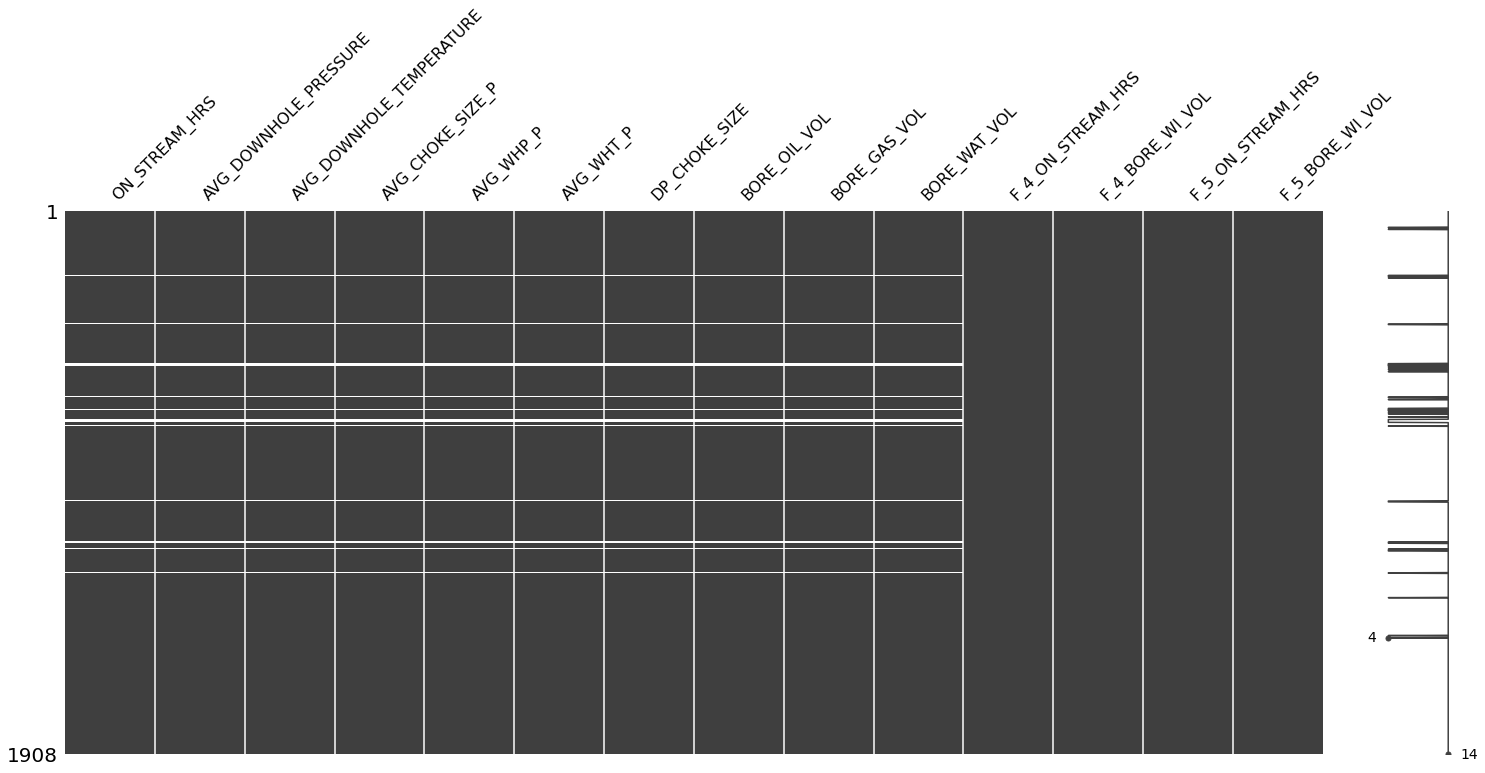

In [ ]:
msno.matrix(df)

In [ ]:
df[df.isnull().any(axis=1)].describe()


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.000000,64.000000,64.000000,64.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.358594,368.638969,0.723177,531.723284
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.928200,1596.277243,3.509475,2340.174060
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.158330,10681.458016,23.833330,16544.539694


In [ ]:
# only 7 and 8 vobservations of injectors data are non-zeroes
df[df.isnull().any(axis=1)].loc[df[df.isnull().any(axis=1)]["F_4_BORE_WI_VOL"] > 0].shape, df[
    df.isnull().any(axis=1)].loc[df[df.isnull().any(axis=1)]["F_5_BORE_WI_VOL"] > 0].shape

((7, 14), (8, 14))

In [ ]:
# total missing values
df.isnull().sum()

ON_STREAM_HRS               64
AVG_DOWNHOLE_PRESSURE       64
AVG_DOWNHOLE_TEMPERATURE    64
AVG_CHOKE_SIZE_P            64
AVG_WHP_P                   64
AVG_WHT_P                   64
DP_CHOKE_SIZE               64
BORE_OIL_VOL                64
BORE_GAS_VOL                64
BORE_WAT_VOL                64
F_4_ON_STREAM_HRS            0
F_4_BORE_WI_VOL              0
F_5_ON_STREAM_HRS            0
F_5_BORE_WI_VOL              0
dtype: int64

In [ ]:
mask = df.isnull() #a boolean array that indicates the positions where a condition is true
df.loc[mask.any(axis=1),:]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,,,
2010-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000
2010-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000
2010-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000
2010-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,23.83333,16544.539694
2010-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000
2013-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.40833,1883.72010,2.40833,2014.459752
2013-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.000000


In [ ]:
df_imputed = df.copy()
df_imputed.interpolate(inplace=True)

In [ ]:
# compare between the statistics before and after imputation to check the influnece of the innterpolated values on the data distribution
print(df_imputed.describe().iloc[:,7])
print(df.describe().iloc[:,7])
print(df.corr('spearman').loc[:,'BORE_OIL_VOL'])
print(df_imputed.corr('spearman').loc[:,'BORE_OIL_VOL'])

count     1908.000000
mean      7103.075974
std       5026.233475
min          0.000000
25%       2835.069230
50%       6121.652514
75%      10939.254320
max      20005.937677
Name: BORE_OIL_VOL, dtype: float64
count     1844.000000
mean      7198.413035
std       5051.706513
min          0.000000
25%       2866.486834
50%       6217.257635
75%      11164.665407
max      20005.937677
Name: BORE_OIL_VOL, dtype: float64
ON_STREAM_HRS               0.404832
AVG_DOWNHOLE_PRESSURE      -0.678876
AVG_DOWNHOLE_TEMPERATURE    0.924401
AVG_CHOKE_SIZE_P           -0.167710
AVG_WHP_P                   0.663049
AVG_WHT_P                   0.558780
DP_CHOKE_SIZE               0.629242
BORE_OIL_VOL                1.000000
BORE_GAS_VOL                0.998349
BORE_WAT_VOL                0.163822
F_4_ON_STREAM_HRS           0.365837
F_4_BORE_WI_VOL             0.465263
F_5_ON_STREAM_HRS           0.356427
F_5_BORE_WI_VOL             0.587557
Name: BORE_OIL_VOL, dtype: float64
ON_STREAM_HRS            

In [ ]:
# total missing values
df_imputed.isnull().sum().sum()

0

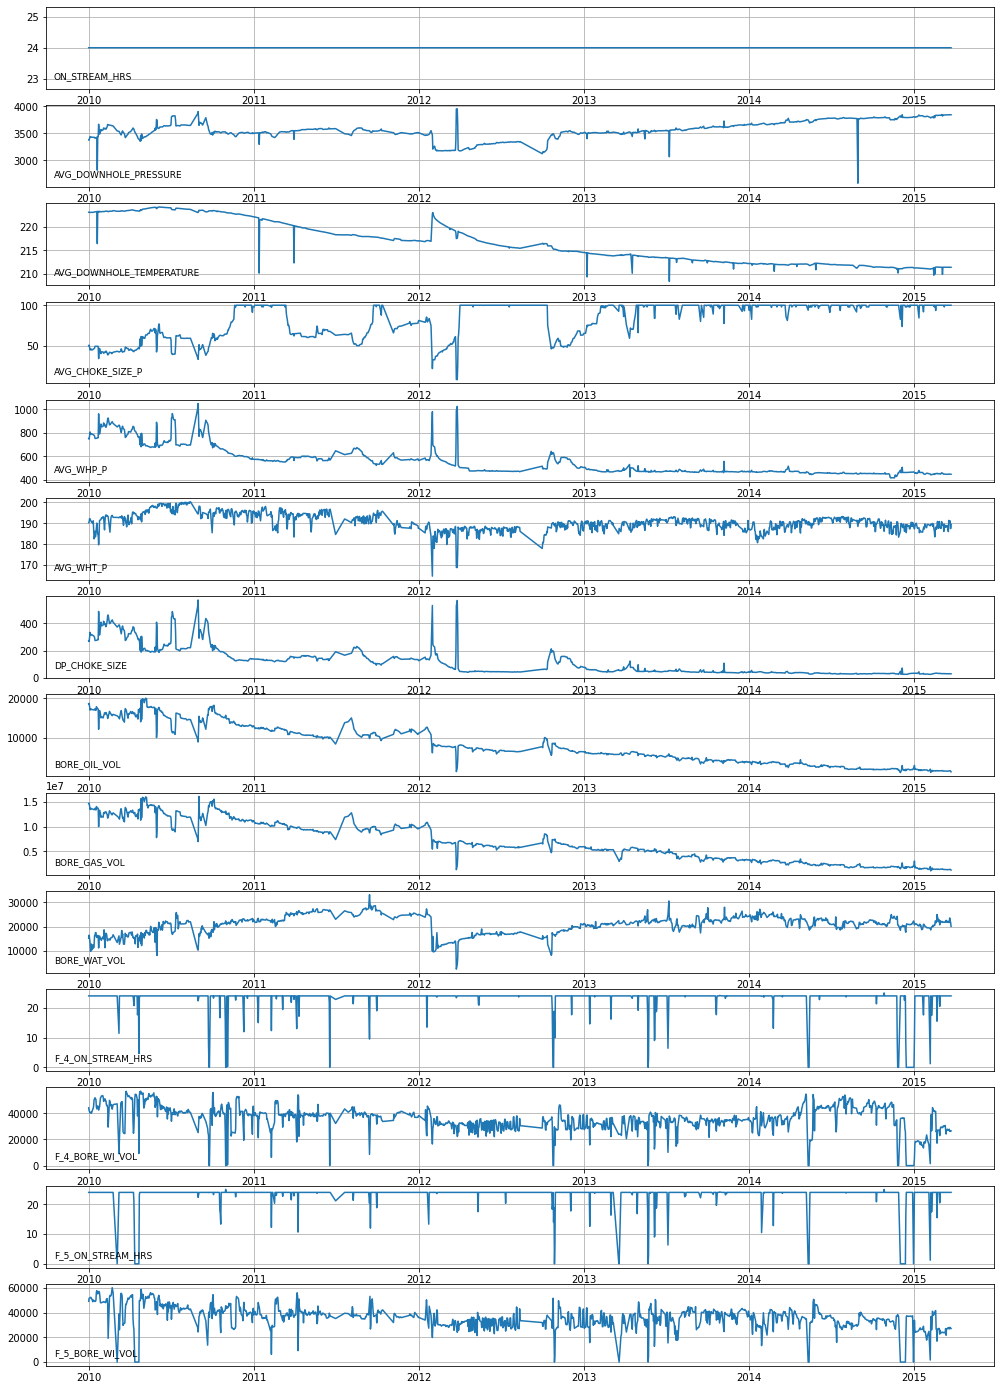

In [ ]:
# Data visulaization and disribution plots for well F-14 after including the injectors
data = df_imputed.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 25))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(df_imputed.loc[df_imputed["ON_STREAM_HRS"] ==24 ][column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
df_imputed.to_csv("cleaned_df.csv")